In [1]:
import numpy as np
import pandas as pd
import time, os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

In [2]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, adjusted_mutual_info_score
from sklearn.metrics import multilabel_confusion_matrix

In [5]:
import tcremb.ml_utils as ml_utils
import benchmark.models as models

import benchmark.metrics as metrics
#import tcremb.TCRemb as TCRemb

In [4]:
import benchmark.models_tcrdist as models_tcrdist

/home/ykremlyakova/.conda/envs/tcrdist/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
tcr_columns_paired = {'TRA':['a_cdr3aa','TRAV','TRAJ'],'TRB':['b_cdr3aa','TRBV','TRBJ']}
label = 'antigen.epitope'
label_s = 'antigen.species'
#label = 'antigen.species_freq'
#output_suf = 'vdjdb_freq'
output_suf = 'vdjdb'
output_suf_s = 'vdjdb_s'

# Clustering

## VDJdb V10-V1000

In [7]:
#samples_n = [10,50,100,500,1000]
samples_n_b = [10,50,100]
samples_n = [10]

In [8]:
tcrdist_res_v = {}
metrics_tcrdist_v = {}

giana_res_raw_v = {}
giana_res_v = {}
metrics_giana_v = {}

ismart_res_raw_v = {}
ismart_res_v = {}
metrics_ismart_v = {}

tcremb_res_v = {}
tcremb_res_raw_v = {}
metrics_tcremb_v = {}

tcremb_res_v_dbscan = {}
metrics_tcremb_v_dbscan = {}

metrics_tcremb_v_all_clstr = {}
metrics_tcremb_v_enriched = {}

### TCRDIST3 vs TRCemb

In [9]:
eps_l = [0.1,0.5,1,5,10,100,750,900,1000, 1100,1200,1300,1400,1500]

In [10]:
chain = 'TRA_TRB'
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_V{i}.csv',sep='\t')
    vdjdb_v['TRAV']= vdjdb_v['TRAV'] + '*01'
    vdjdb_v['TRBV']= vdjdb_v['TRBV'] + '*01'
    vdjdb_v['TRAJ']= vdjdb_v['TRAJ'] + '*01'
    vdjdb_v['TRBJ']= vdjdb_v['TRBJ'] + '*01'
    vdjdb_v['TRAV'] = vdjdb_v['TRAV'].str.replace('DV','/DV')
    
    if chain == 'TRA_TRB':
        vdjdb_v = vdjdb_v[~(vdjdb_v['a_cdr3aa'].isna()|vdjdb_v['b_cdr3aa'].isna())].drop_duplicates(tcr_columns_paired['TRA'] + tcr_columns_paired['TRB']).reset_index(drop=True)
    else:
        vdjdb_v = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()].drop_duplicates(list(tcr_columns_paired[chain])).reset_index(drop=True)
    
    print(len(vdjdb_v))
    
    tcrdist_res_v[chain] = models_tcrdist.run_tcrdist3_set(vdjdb_v,chain, f'V{i}', eps=eps_l)
    #tcrdist_res[chain] = models_tcrdist.run_tcrdist3(vdjdb_data_tcrdist3)

5558

*** Tcrdist3 clustering 5558 TRA_TRB chains 


In [11]:
for i in eps_l:
    print(metrics.get_clustermetrics(tcrdist_res_v[chain][i], 'antigen.epitope'))

{'purity': 1.0, 'retention': 0.02, 'consistency': 0.0293, 'ami': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'mean_clustsize': 2.41}
{'purity': 1.0, 'retention': 0.02, 'consistency': 0.0293, 'ami': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'mean_clustsize': 2.41}
{'purity': 1.0, 'retention': 0.02, 'consistency': 0.0293, 'ami': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'mean_clustsize': 2.41}
{'purity': 1.0, 'retention': 0.02, 'consistency': 0.0293, 'ami': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'mean_clustsize': 2.41}
{'purity': 1.0, 'retention': 0.02, 'consistency': 0.0293, 'ami': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'mean_clustsize': 2.41}
{'purity': 1.0, 'retention': 0.02, 'consistency': 0.0244, 'ami': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'mean_clustsize': 2.4}
{'purity': 0.99, 'retention': 0.21, 'consistency': 0.0048, 'ami': 0.98, 'precision': 0.99, 'recall': 0.99, 'f1-score': 0.99, 'mean_clusts

In [24]:
chain = 'TRA_TRB'
tcremb_res_raw_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_raw_v[chain][i] = models.run_tcremb(v_path, chain, f'V{i}',skip_scores=True, model='dbscan')

TCR-epitope paires count in V10 dataset: 34273
data/data_preped/VDJdb_data_V10.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_V10.csv --runname compare_V10 --chain TRA_TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


Traceback (most recent call last):
  File "/home/ykremlyakova/projects/tcr_emb/tcremb_run.py", line 17, in <module>
    import tcremb.TCRemb as TCRemb
  File "/home/ykremlyakova/projects/tcr_emb/tcremb/TCRemb.py", line 9, in <module>
    from mir.common import parser, Repertoire, SegmentLibrary
  File "/home/ykremlyakova/projects/tcr_emb/mir/common/__init__.py", line 3, in <module>
    from .segments import Segment, SegmentLibrary
  File "/home/ykremlyakova/projects/tcr_emb/mir/common/segments.py", line 72, in <module>
    class SegmentLibrary:
  File "/home/ykremlyakova/projects/tcr_emb/mir/common/segments.py", line 162, in SegmentLibrary
    def get_or_create(self, s: str | Segment,
TypeError: unsupported operand type(s) for |: 'type' and 'type'


Elapsed time: 8.549524068832397 seconds.


In [29]:
## work with results
chain = 'TRA_TRB'
tcremb_res_raw_v[chain]={}
tcremb_res_v[chain]={}
metrics_tcremb_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    tcremb_res_raw_v[chain][i] = pd.read_csv(f'tcremb_outputs/compare_V{i}/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_raw_v[chain][i])}")
    
    tcremb_res_v[chain][i] = vdjdb_v[~(vdjdb_v[tcr_columns_paired['TRA'][0]].isna()&vdjdb_v[tcr_columns_paired['TRB'][0]].isna())][['data_id',tcr_columns_paired['TRA'][0],tcr_columns_paired['TRA'][2],tcr_columns_paired['TRB'][0],tcr_columns_paired['TRB'][2],'antigen.epitope']].merge(tcremb_res_raw_v[chain][i], how = 'left')
    tcremb_res_v[chain][i]['is_cluster'] = tcremb_res_v[chain][i]['is_cluster'].fillna(0)
    
    #print(ml_utils.clsf_metrics(tcremb_res_v[chain][i]['antigen.epitope'],tcremb_res_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v[chain][i] = metrics.get_clustermetrics(tcremb_res_v[chain][i], 'antigen.epitope')
    metrics_tcremb_v[chain][i]['method']='TCRemb'
    print(metrics_tcremb_v[chain][i])

TCR-epitope paires count in V10 dataset: 5044
0.963963963963964
{'purity': 0.96, 'retention': 0.05, 'consistency': 0.0082, 'ami': 0.94, 'precision': 0.96, 'recall': 0.96, 'f1-score': 0.96, 'mean_clustsize': 6.56, 'method': 'TCRemb'}


In [5]:
chain='TRA_TRB'
i=10
v_path = f'data/data_preped/VDJdb_data_V{i}.csv'
vdjdb_v = pd.read_csv(v_path,sep='\t')
run_name=f'compare_V{i}'

In [6]:
unique_clonotypes=True
tcremb = TCRemb.TCRemb(run_name, vdjdb_v)
tcremb.tcremb_clonotypes(chain, unique_clonotypes=unique_clonotypes)
tcremb.tcremb_dists(chain)
tcremb.tcremb_pca(chain)
tcremb.tcremb_tsne(chain)

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [7]:
method= run_name + '_DBSCAN'
dbscan = TCRemb.TCRemb_clustering('DBSCAN')
metrics_dbscan = {}

In [8]:

metrics_dbscan[label]={}

In [9]:

#coef = 0.85
#model = DBSCAN(eps=round(float(eps_by_knee_dict[chain]['knee'])*coef,2), min_samples=2)
dbscan.clstr(chain,tcremb, label, on_pca=False)

purity:0.9802955665024631


In [10]:
df = tcremb.annot_input[chain].merge(dbscan.clstr_labels[chain], how='left')
df['is_cluster'] = df['is_cluster'].fillna(0)
metrics_dbscan[label][chain] = metrics.get_clustermetrics(df, label)
metrics_dbscan[label][chain]['total pairs TCR-epitope'] = len(tcremb.annot[chain])
metrics_dbscan[label][chain]['total unique TCRs'] = str(len(tcremb.annot[chain].drop_duplicates(tcremb.clonotype_id)))
metrics_dbscan[label][chain]['total unique epitopes'] = str(len(tcremb.annot[chain].drop_duplicates(label)))
metrics_dbscan[label][chain]['label']=label
metrics_dbscan[label][chain]


{'purity': 0.98,
 'retention': 0.31,
 'consistency': 0.0102,
 'ami': 0.96,
 'precision': 0.98,
 'recall': 0.98,
 'f1-score': 0.98,
 'mean_clustsize': 5.85,
 'total pairs TCR-epitope': 4572,
 'total unique TCRs': '4572',
 'total unique epitopes': '104',
 'label': 'antigen.epitope'}

### ismart

In [23]:
## Run ismart
chain = 'TRA'
ismart_res_raw_v[chain]={}
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    ismart_res_raw_v[chain][i] = models.run_ismart(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 10288
Clustering 10288 sequences with iSMART.

iSMARTf is intended to perform pairwise CDR3 alignment for large volume (10^6-10^8) of sequneces. It implements
k-mer based clustering to recursively reduce the search space, and report sequences with high similarity.
Currently, gap is not supported. 

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

Processing data.txt
Done! Time Elapsed 3.295024
Performing pairwise alignment
Number of pairs to be processed: 606770
Done!
Dividing CDR3s into clusters
    Solved 200 clusters
    Solved 400 clusters
    Solved 600 clusters
Done! Time Elapsed 22.214449
Total time elapsed: 30.309557
Maximum memory usage: 0.109176 MB
Elapsed time: 31.986326456069946 seconds.
TCR-epitope paires count in V50 dataset: 9281
Clusteri

In [24]:
## Run ismart
chain = 'TRB'
ismart_res_raw_v[chain]={}
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    ismart_res_raw_v[chain][i] = models.run_ismart(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 21991
Clustering 21991 sequences with iSMART.

iSMARTf is intended to perform pairwise CDR3 alignment for large volume (10^6-10^8) of sequneces. It implements
k-mer based clustering to recursively reduce the search space, and report sequences with high similarity.
Currently, gap is not supported. 

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

Processing data.txt
Done! Time Elapsed 6.096567
Performing pairwise alignment
Number of pairs to be processed: 2553420
Processed 1000000 pairs. Elapsed time 19.188994
Processed 2000000 pairs. Elapsed time 50.861134
Done!
Dividing CDR3s into clusters
    Solved 200 clusters
    Solved 400 clusters
    Solved 600 clusters
    Solved 800 clusters
Done! Time Elapsed 65.606739
Total time elapsed: 69.572871
Maximum m

In [25]:
## work with results
chain = 'TRA'
ismart_res_raw_v[chain]={}
ismart_res_v[chain]={}
metrics_ismart_v[chain]={}

for i in samples_n:
    ismart_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()])}")
    
    ismart_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(ismart_res_raw_v[chain][i], how = 'left')
    ismart_res_v[chain][i]['is_cluster'] = ismart_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(ismart_res_raw_v[chain][i]['antigen.epitope'],ismart_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(ismart_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_ismart_v[chain][i] = metrics.get_clustermetrics(ismart_res_v[chain][i], 'antigen.epitope')
    metrics_ismart_v[chain][i]['method']='iSmart'
    print(metrics_ismart_v[chain][i])

TCR-epitope paires count in V10 dataset: 10288
{'f1': 0.8527657093542841, 'precision': 0.857710239750205, 'recall': 0.8566536203522505}
0.8566536203522505
{'purity': 0.86, 'retention': 0.2, 'consistency': 0.0027, 'ami': 0.74, 'precision': 0.86, 'recall': 0.86, 'f1-score': 0.86, 'mean_clustsize': 3.37, 'method': 'iSmart'}
TCR-epitope paires count in V50 dataset: 9281


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.8742829831877038, 'precision': 0.8762887122495813, 'recall': 0.8763557483731019}
0.8763557483731019
{'purity': 0.88, 'retention': 0.2, 'consistency': 0.0052, 'ami': 0.75, 'precision': 0.88, 'recall': 0.88, 'f1-score': 0.88, 'mean_clustsize': 3.45, 'method': 'iSmart'}
TCR-epitope paires count in V100 dataset: 8584
{'f1': 0.8920040164430628, 'precision': 0.8949882365792315, 'recall': 0.8934226552984166}
0.8934226552984166
{'purity': 0.89, 'retention': 0.19, 'consistency': 0.0071, 'ami': 0.75, 'precision': 0.89, 'recall': 0.89, 'f1-score': 0.89, 'mean_clustsize': 3.45, 'method': 'iSmart'}
TCR-epitope paires count in V500 dataset: 5738
{'f1': 0.9395266455204492, 'precision': 0.939579246938667, 'recall': 0.9398704902867715}
0.9398704902867715
{'purity': 0.94, 'retention': 0.19, 'consistency': 0.0315, 'ami': 0.73, 'precision': 0.94, 'recall': 0.94, 'f1-score': 0.94, 'mean_clustsize': 3.87, 'method': 'iSmart'}
TCR-epitope paires count in V1000 dataset: 5091
{'f1': 0.9473015802821901,

In [26]:
## work with results
chain = 'TRB'
ismart_res_raw_v[chain]={}
ismart_res_v[chain]={}
metrics_ismart_v[chain]={}

for i in samples_n:
    # 200524 ismart_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_V{i}.txt',sep='\t')
    ismart_res_v[chain][i] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_V{i}.txt',sep='\t')
    
    # 200524printvdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    # 200524printvdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    # 200524printvdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    # 200524printprint(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()])}")
    
    # 200524ismart_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(ismart_res_raw_v[chain][i], how = 'left')
    # 200524ismart_res_v[chain][i]['is_cluster'] = ismart_res_v[chain][i]['is_cluster'].fillna(0)
    
    # 200524print(ml_utils.clsf_metrics(ismart_res_raw_v[chain][i]['antigen.epitope'],ismart_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    # 200524printprint(ml_utils.count_clstr_purity(ismart_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_ismart_v[chain][i] = metrics.get_clustermetrics(ismart_res_v[chain][i], 'antigen.epitope')
    metrics_ismart_v[chain][i]['method']='iSmart'
    print(metrics_ismart_v[chain][i])

TCR-epitope paires count in V10 dataset: 21991
{'f1': 0.9180782724959399, 'precision': 0.9226548120258936, 'recall': 0.921021377672209}
0.921021377672209


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.92, 'retention': 0.15, 'consistency': 0.0017, 'ami': 0.88, 'precision': 0.92, 'recall': 0.92, 'f1-score': 0.92, 'mean_clustsize': 3.64, 'method': 'iSmart'}
TCR-epitope paires count in V50 dataset: 19775
{'f1': 0.9327973524070138, 'precision': 0.9360729104467291, 'recall': 0.9342411159083361}
0.9342411159083361


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.93, 'retention': 0.15, 'consistency': 0.0029, 'ami': 0.89, 'precision': 0.94, 'recall': 0.93, 'f1-score': 0.94, 'mean_clustsize': 3.69, 'method': 'iSmart'}
TCR-epitope paires count in V100 dataset: 17813
{'f1': 0.9413592281978996, 'precision': 0.9449972199132511, 'recall': 0.9430167597765363}
0.9430167597765363
{'purity': 0.94, 'retention': 0.15, 'consistency': 0.0046, 'ami': 0.89, 'precision': 0.94, 'recall': 0.94, 'f1-score': 0.94, 'mean_clustsize': 3.86, 'method': 'iSmart'}


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TCR-epitope paires count in V500 dataset: 11303
{'f1': 0.9741063595351519, 'precision': 0.9748732912083189, 'recall': 0.9747561675272519}
0.9747561675272519
{'purity': 0.97, 'retention': 0.15, 'consistency': 0.0244, 'ami': 0.9, 'precision': 0.97, 'recall': 0.97, 'f1-score': 0.97, 'mean_clustsize': 4.5, 'method': 'iSmart'}
TCR-epitope paires count in V1000 dataset: 8852
{'f1': 0.9746897402222666, 'precision': 0.9749086406647978, 'recall': 0.9750195160031225}
0.9750195160031225
{'purity': 0.98, 'retention': 0.14, 'consistency': 0.0562, 'ami': 0.83, 'precision': 0.97, 'recall': 0.98, 'f1-score': 0.97, 'mean_clustsize': 4.85, 'method': 'iSmart'}


### GIANA

In [27]:
## Run Giana
chain = 'TRA'
giana_res_raw_v[chain]={}
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_raw_v[chain][i] = models.run_GIANA(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 10288
GIANA clustering of 10288 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.735868
Maximum memory usage: 0.187672 MB
Elapsed time: 9.034437417984009 seconds.
TCR-epitope paires count in V50 dataset: 9281
GIANA clustering of 9281 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.376943
Maximum memory usage: 0.188468 MB
Elapsed time: 6.131165504455566 seconds.
TCR-epitope paires count in V100 dataset: 8584
GIANA clustering of 8584 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.283250
Maximum memory usage: 0.185736 MB
Elapsed time: 5.99989128112793 seconds.
TCR-epitope paires count in V500 dataset: 5738
GIANA clustering of 5738 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 0.859907
Maximum memory usage: 0.176528 MB
Elapsed time: 5.637770891189575 seconds.
TCR-epitope paires count in V1000 dataset: 5091
GIANA clustering of 5091 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 0.819247
Maximum memory usage: 0.179196 MB
Elapsed time: 5.774123430252075 seconds.


In [28]:
## Run Giana
chain = 'TRB'
giana_res_raw_v[chain]={}
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_raw_v[chain][i] = models.run_GIANA(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 21991
GIANA clustering of 21991 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 2.161333
Maximum memory usage: 0.210836 MB
Elapsed time: 7.08753776550293 seconds.
TCR-epitope paires count in V50 dataset: 19775
GIANA clustering of 19775 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.895391
Maximum memory usage: 0.209236 MB
Elapsed time: 6.639816761016846 seconds.
TCR-epitope paires count in V100 dataset: 17813
GIANA clustering of 17813 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.763707
Maximum memory usage: 0.202548 MB
Elapsed time: 6.577954053878784 seconds.
TCR-epitope paires count in V500 dataset: 11303
GIANA clustering of 11303 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.096386
Maximum memory usage: 0.186940 MB
Elapsed time: 5.8537514209747314 seconds.
TCR-epitope paires count in V1000 dataset: 8852
GIANA clustering of 8852 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.213331
Maximum memory usage: 0.183844 MB
Elapsed time: 6.058655023574829 seconds.


In [29]:
## work with results
chain = 'TRA'
giana_res_raw_v[chain]={}
giana_res_v[chain]={}
metrics_giana_v[chain]={}
for i in samples_n:
    giana_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()])}")
    
    giana_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(giana_res_raw_v[chain][i], how = 'left')
    giana_res_v[chain][i]['is_cluster'] = giana_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(giana_res_raw_v[chain][i]['antigen.epitope'],giana_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(giana_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_giana_v[chain][i] = metrics.get_clustermetrics(giana_res_v[chain][i], 'antigen.epitope')
    metrics_giana_v[chain][i]['method']='GIANA'
    print(metrics_giana_v[chain][i])

TCR-epitope paires count in V10 dataset: 10288
{'f1': 0.5483096145402606, 'precision': 0.5708528488596213, 'recall': 0.5712665406427221}
0.5711854792966534


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.57, 'retention': 0.51, 'consistency': 0.0012, 'ami': 0.32, 'precision': 0.57, 'recall': 0.57, 'f1-score': 0.57, 'mean_clustsize': 5.03, 'method': 'GIANA'}
TCR-epitope paires count in V50 dataset: 9281
{'f1': 0.5995782802246269, 'precision': 0.6127818061761581, 'recall': 0.6131994873985477}
0.6131168553727836
{'purity': 0.61, 'retention': 0.5, 'consistency': 0.0027, 'ami': 0.34, 'precision': 0.61, 'recall': 0.61, 'f1-score': 0.61, 'mean_clustsize': 4.93, 'method': 'GIANA'}
TCR-epitope paires count in V100 dataset: 8584
{'f1': 0.6171840411267733, 'precision': 0.631418535299684, 'recall': 0.6368124118476728}
0.636727016223842
{'purity': 0.64, 'retention': 0.5, 'consistency': 0.0036, 'ami': 0.32, 'precision': 0.63, 'recall': 0.64, 'f1-score': 0.63, 'mean_clustsize': 4.84, 'method': 'GIANA'}
TCR-epitope paires count in V500 dataset: 5738
{'f1': 0.7986514580085345, 'precision': 0.7984209920067002, 'recall': 0.7990936555891238}
0.7990177559501322
{'purity': 0.8, 'retention': 0.46

In [30]:
## work with results
chain = 'TRB'
giana_res_raw_v[chain]={}
giana_res_v[chain]={}
metrics_giana_v[chain]={}
for i in samples_n:
    giana_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()])}")
    
    giana_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(giana_res_raw_v[chain][i], how = 'left')
    giana_res_v[chain][i]['is_cluster'] = giana_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(giana_res_raw_v[chain][i]['antigen.epitope'],giana_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(giana_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_giana_v[chain][i] = metrics.get_clustermetrics(giana_res_v[chain][i], 'antigen.epitope')
    metrics_giana_v[chain][i]['method']='GIANA'
    print(metrics_giana_v[chain][i])

TCR-epitope paires count in V10 dataset: 21991
{'f1': 0.7654143683890098, 'precision': 0.769942490175347, 'recall': 0.7774834437086092}
0.7774413323239969


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.78, 'retention': 0.24, 'consistency': 0.001, 'ami': 0.67, 'precision': 0.77, 'recall': 0.78, 'f1-score': 0.77, 'mean_clustsize': 3.64, 'method': 'GIANA'}
TCR-epitope paires count in V50 dataset: 19775
{'f1': 0.8014515361489236, 'precision': 0.8075192150625413, 'recall': 0.8069349315068494}
0.8068935988011132
{'purity': 0.81, 'retention': 0.24, 'consistency': 0.0023, 'ami': 0.68, 'precision': 0.81, 'recall': 0.81, 'f1-score': 0.81, 'mean_clustsize': 3.64, 'method': 'GIANA'}
TCR-epitope paires count in V100 dataset: 17813
{'f1': 0.8175571340421599, 'precision': 0.8240503016169168, 'recall': 0.822883630153696}
0.8228404099560761
{'purity': 0.82, 'retention': 0.23, 'consistency': 0.0037, 'ami': 0.68, 'precision': 0.82, 'recall': 0.82, 'f1-score': 0.82, 'mean_clustsize': 3.75, 'method': 'GIANA'}
TCR-epitope paires count in V500 dataset: 11303
{'f1': 0.898096323858538, 'precision': 0.8986673511374782, 'recall': 0.9013131715081576}
0.9012738853503185
{'purity': 0.9, 'retention': 

### TCRemb

In [33]:
chain = 'TRA'
tcremb_res_raw_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_raw_v[chain][i] = models.run_tcremb(v_path, chain, f'V{i}',skip_scores=True, model='dbscan')

TCR-epitope paires count in V10 dataset: 10288
data/data_preped/VDJdb_data_TRA_V10.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V10.csv --runname compare_V10 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V10.csv
purity:0.8793969849246231
Results are in tcremb_outputs/compare_V10/
Elapsed time: 83.53329920768738 seconds.
TCR-epitope paires count in V50 dataset: 9281
data/data_preped/VDJdb_data_TRA_V50.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V50.csv --runname compare_V50 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V50.csv
purity:0.900093370681606
Results are in tcremb_outputs/compare_V50/
Elapsed time: 57.128838300704956 seconds.
TCR-epitope paires count in V100 dataset: 8584
data/data_preped/VDJdb_data_TRA_V100.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V100.csv --runname compare_V100 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V100.csv
purity:0.9099476439790576
Results are in tcremb_outputs/compare_V100/
Elapsed time: 52.97722911834717 seconds.
TCR-epitope paires count in V500 dataset: 5738
data/data_preped/VDJdb_data_TRA_V500.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V500.csv --runname compare_V500 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V500.csv
purity:0.9008264462809917
Results are in tcremb_outputs/compare_V500/
Elapsed time: 35.349215507507324 seconds.
TCR-epitope paires count in V1000 dataset: 5091
data/data_preped/VDJdb_data_TRA_V1000.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V1000.csv --runname compare_V1000 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V1000.csv
purity:0.9066147859922179
Results are in tcremb_outputs/compare_V1000/
Elapsed time: 31.519769430160522 seconds.


In [34]:
chain = 'TRB'
tcremb_res_raw_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_raw_v[chain][i] = models.run_tcremb(v_path, chain, f'V{i}',skip_scores=True, model='dbscan')

TCR-epitope paires count in V10 dataset: 21991
data/data_preped/VDJdb_data_TRB_V10.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V10.csv --runname compare_V10 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V10.csv
purity:0.8975583864118896
Results are in tcremb_outputs/compare_V10/
Elapsed time: 136.1449680328369 seconds.
TCR-epitope paires count in V50 dataset: 19775
data/data_preped/VDJdb_data_TRB_V50.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V50.csv --runname compare_V50 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V50.csv
purity:0.9118751805836464
Results are in tcremb_outputs/compare_V50/
Elapsed time: 127.79131507873535 seconds.
TCR-epitope paires count in V100 dataset: 17813
data/data_preped/VDJdb_data_TRB_V100.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V100.csv --runname compare_V100 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V100.csv
purity:0.9196736743018513
Results are in tcremb_outputs/compare_V100/
Elapsed time: 109.96127009391785 seconds.
TCR-epitope paires count in V500 dataset: 11303
data/data_preped/VDJdb_data_TRB_V500.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V500.csv --runname compare_V500 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V500.csv
purity:0.9470899470899471
Results are in tcremb_outputs/compare_V500/
Elapsed time: 66.98703455924988 seconds.
TCR-epitope paires count in V1000 dataset: 8852
data/data_preped/VDJdb_data_TRB_V1000.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V1000.csv --runname compare_V1000 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V1000.csv
purity:0.9500304692260817
Results are in tcremb_outputs/compare_V1000/
Elapsed time: 53.29524874687195 seconds.


In [35]:
## work with results
chain = 'TRA'
tcremb_res_raw_v[chain]={}
tcremb_res_v[chain]={}
metrics_tcremb_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    tcremb_res_raw_v[chain][i] = pd.read_csv(f'tcremb_outputs/compare_V{i}/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_raw_v[chain][i])}")
    
    tcremb_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(tcremb_res_raw_v[chain][i], how = 'left')
    tcremb_res_v[chain][i]['is_cluster'] = tcremb_res_v[chain][i]['is_cluster'].fillna(0)
    
    #print(ml_utils.clsf_metrics(tcremb_res_v[chain][i]['antigen.epitope'],tcremb_res_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v[chain][i] = metrics.get_clustermetrics(tcremb_res_v[chain][i], 'antigen.epitope')
    metrics_tcremb_v[chain][i]['method']='TCRemb'
    print(metrics_tcremb_v[chain][i])

TCR-epitope paires count in V10 dataset: 10277
0.8793969849246231
{'purity': 0.88, 'retention': 0.12, 'consistency': 0.0025, 'ami': 0.79, 'precision': 0.87, 'recall': 0.88, 'f1-score': 0.88, 'mean_clustsize': 2.71, 'method': 'TCRemb'}
TCR-epitope paires count in V50 dataset: 9270
0.900093370681606
{'purity': 0.9, 'retention': 0.12, 'consistency': 0.0042, 'ami': 0.8, 'precision': 0.9, 'recall': 0.9, 'f1-score': 0.9, 'mean_clustsize': 2.75, 'method': 'TCRemb'}
TCR-epitope paires count in V100 dataset: 8574
0.9099476439790576
{'purity': 0.91, 'retention': 0.11, 'consistency': 0.0056, 'ami': 0.8, 'precision': 0.91, 'recall': 0.91, 'f1-score': 0.91, 'mean_clustsize': 2.72, 'method': 'TCRemb'}
TCR-epitope paires count in V500 dataset: 5730
0.9008264462809917
{'purity': 0.9, 'retention': 0.27, 'consistency': 0.0301, 'ami': 0.63, 'precision': 0.9, 'recall': 0.9, 'f1-score': 0.9, 'mean_clustsize': 3.71, 'method': 'TCRemb'}
TCR-epitope paires count in V1000 dataset: 5084
0.9066147859922179
{'pur

In [36]:
## work with results
chain = 'TRB'
tcremb_res_raw_v[chain]={}
tcremb_res_v[chain]={}
metrics_tcremb_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    tcremb_res_raw_v[chain][i] = pd.read_csv(f'tcremb_outputs/compare_V{i}/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_raw_v[chain][i])}")
    
    tcremb_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(tcremb_res_raw_v[chain][i], how = 'left')
    tcremb_res_v[chain][i]['is_cluster'] = tcremb_res_v[chain][i]['is_cluster'].fillna(0)
    
    #print(ml_utils.clsf_metrics(tcremb_res_v[chain][i]['antigen.epitope'],tcremb_res_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v[chain][i] = metrics.get_clustermetrics(tcremb_res_v[chain][i], 'antigen.epitope')
    metrics_tcremb_v[chain][i]['method']='TCRemb'
    print(metrics_tcremb_v[chain][i])

TCR-epitope paires count in V10 dataset: 21971
0.8975583864118896
{'purity': 0.9, 'retention': 0.17, 'consistency': 0.0012, 'ami': 0.84, 'precision': 0.9, 'recall': 0.9, 'f1-score': 0.9, 'mean_clustsize': 3.41, 'method': 'TCRemb'}
TCR-epitope paires count in V50 dataset: 19756
0.9118751805836464
{'purity': 0.91, 'retention': 0.18, 'consistency': 0.002, 'ami': 0.84, 'precision': 0.91, 'recall': 0.91, 'f1-score': 0.91, 'mean_clustsize': 3.49, 'method': 'TCRemb'}
TCR-epitope paires count in V100 dataset: 17797
0.9196736743018513
{'purity': 0.92, 'retention': 0.18, 'consistency': 0.0032, 'ami': 0.84, 'precision': 0.92, 'recall': 0.92, 'f1-score': 0.92, 'mean_clustsize': 3.65, 'method': 'TCRemb'}
TCR-epitope paires count in V500 dataset: 11289
0.9470899470899471
{'purity': 0.95, 'retention': 0.2, 'consistency': 0.0158, 'ami': 0.82, 'precision': 0.95, 'recall': 0.95, 'f1-score': 0.95, 'mean_clustsize': 4.51, 'method': 'TCRemb'}
TCR-epitope paires count in V1000 dataset: 8838
0.95003046922608

### compare

In [37]:
metrics_v = {}

In [38]:
color_map = {'tcrdist':'#fc8d62','GIANA':'#e78ac3','iSmart':'#a6d854','TCRemb':'#66c2a5'}

In [39]:
chain = 'TRA'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v[chain]).T])
#metrics_v[chain]['method'] = metrics_v[chain].index

chain = 'TRB'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v[chain]).T])

### compare all V

In [40]:
metrics_v['TRA']=metrics_v['TRA'].reset_index().rename({'index':'v_subset'},axis=1)
metrics_v['TRB']=metrics_v['TRB'].reset_index().rename({'index':'v_subset'},axis=1)

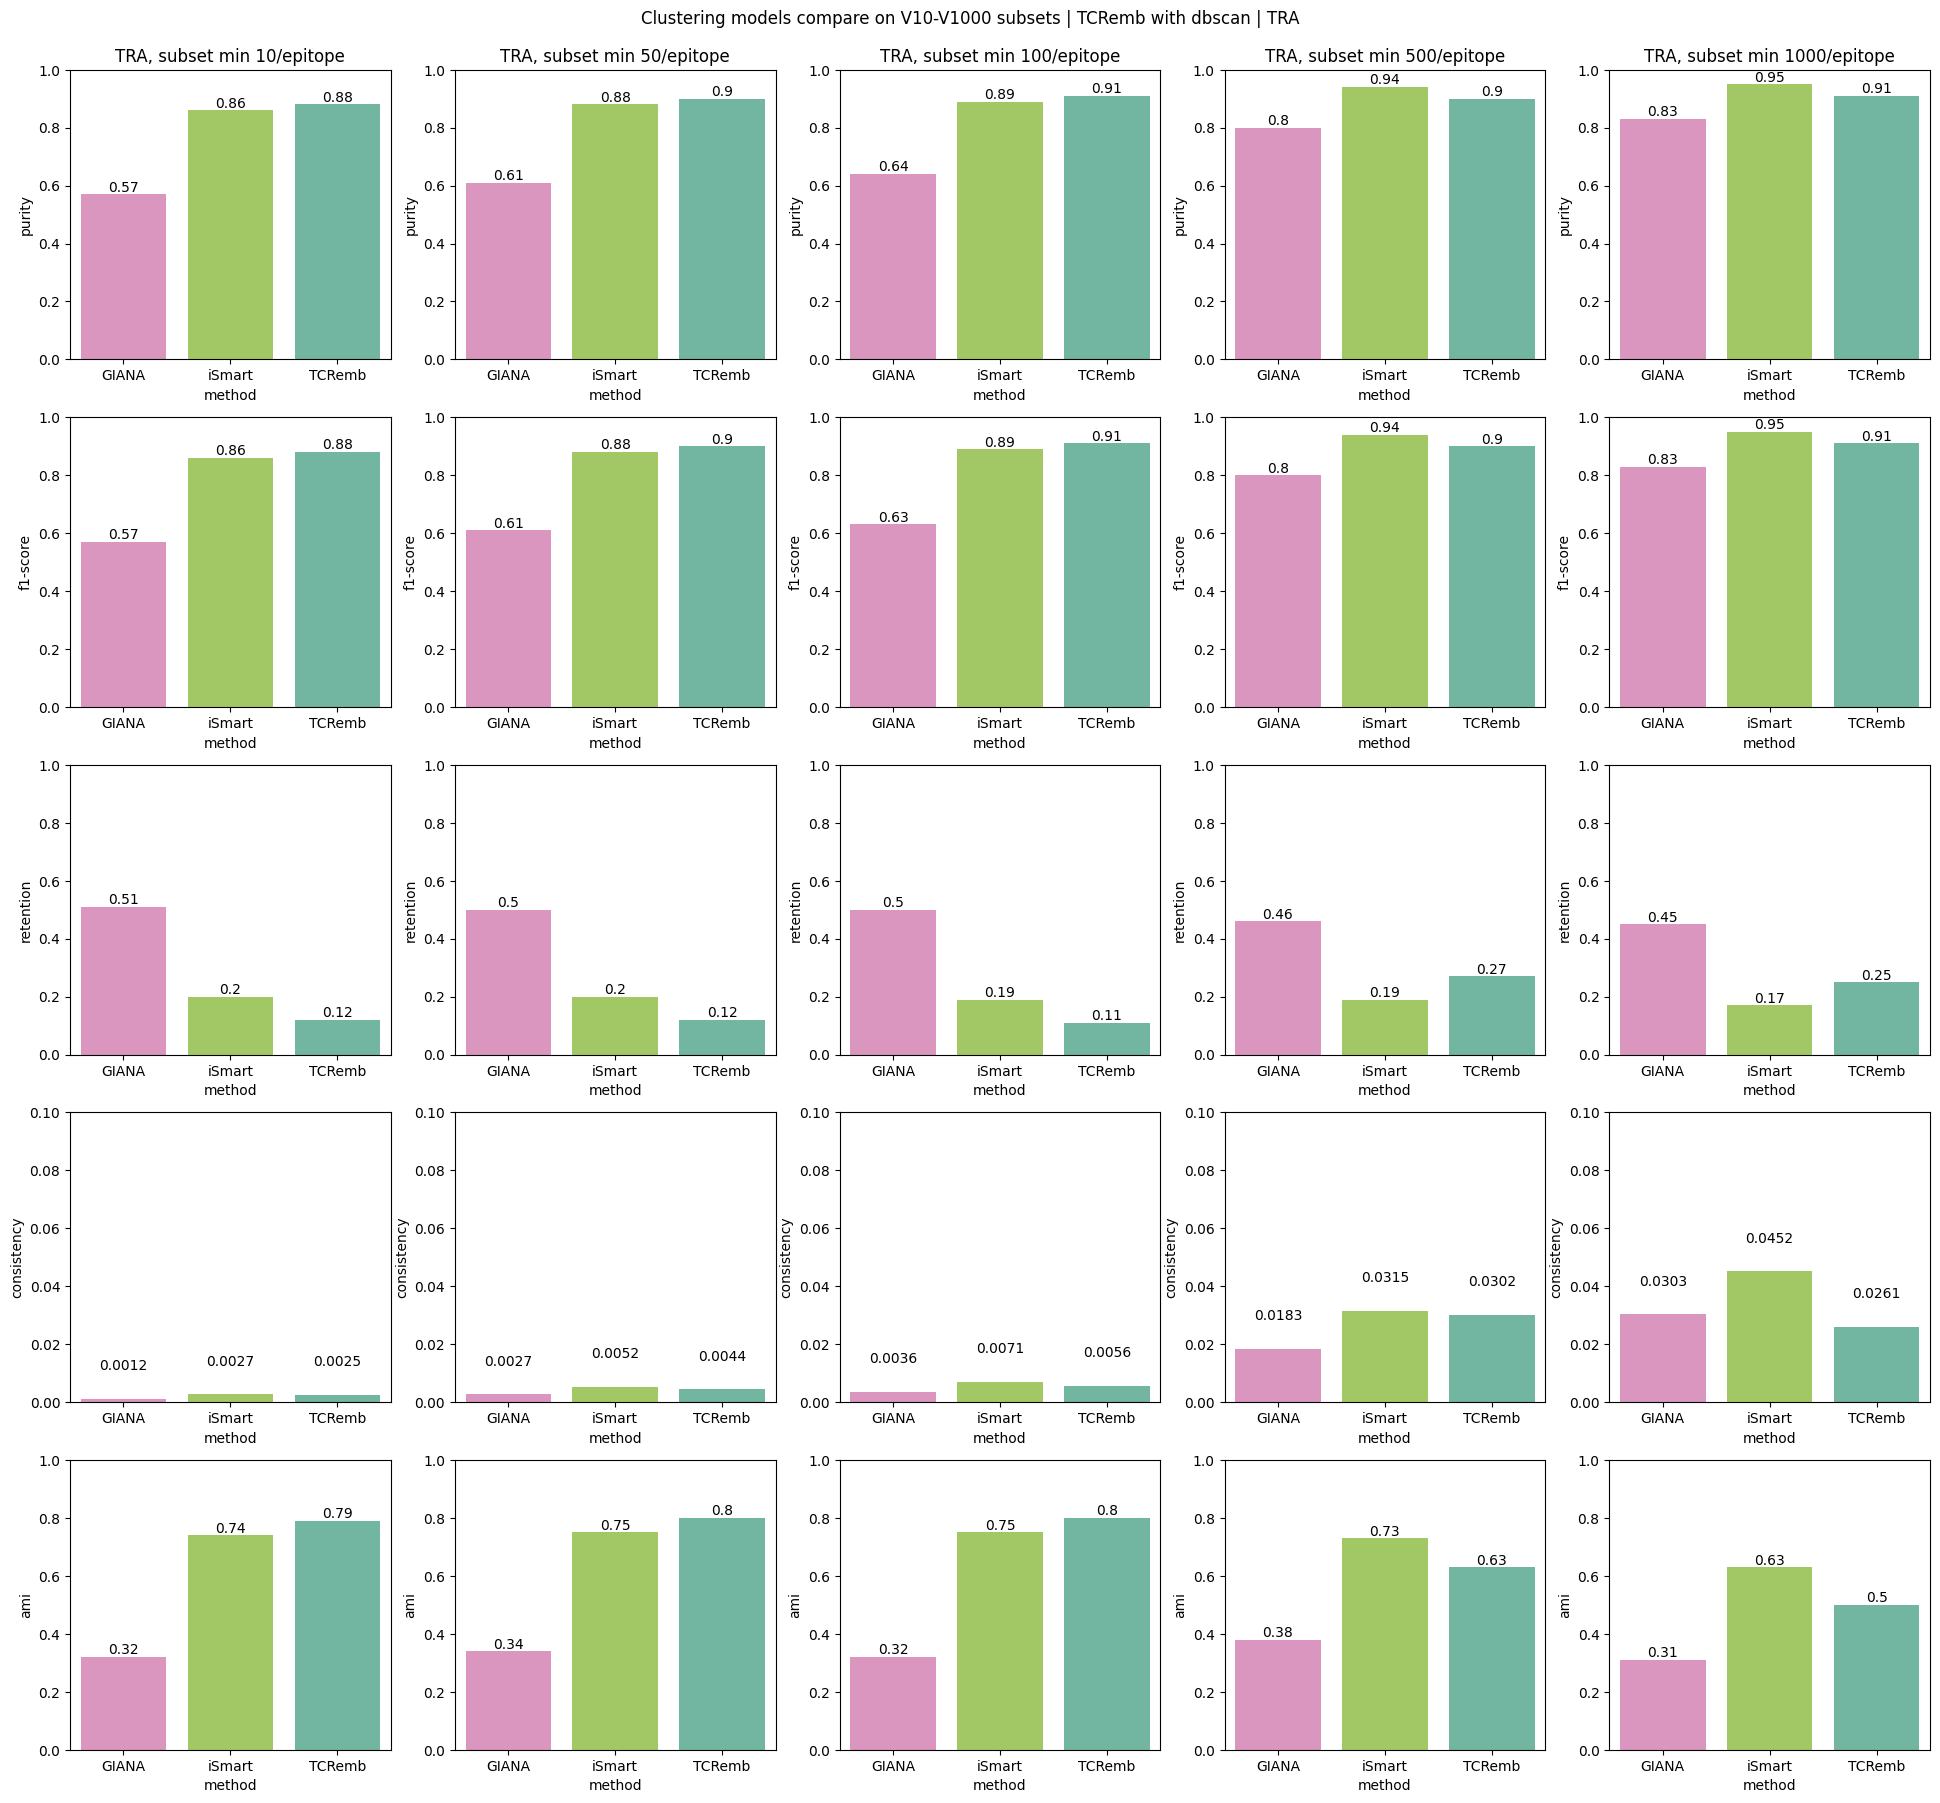

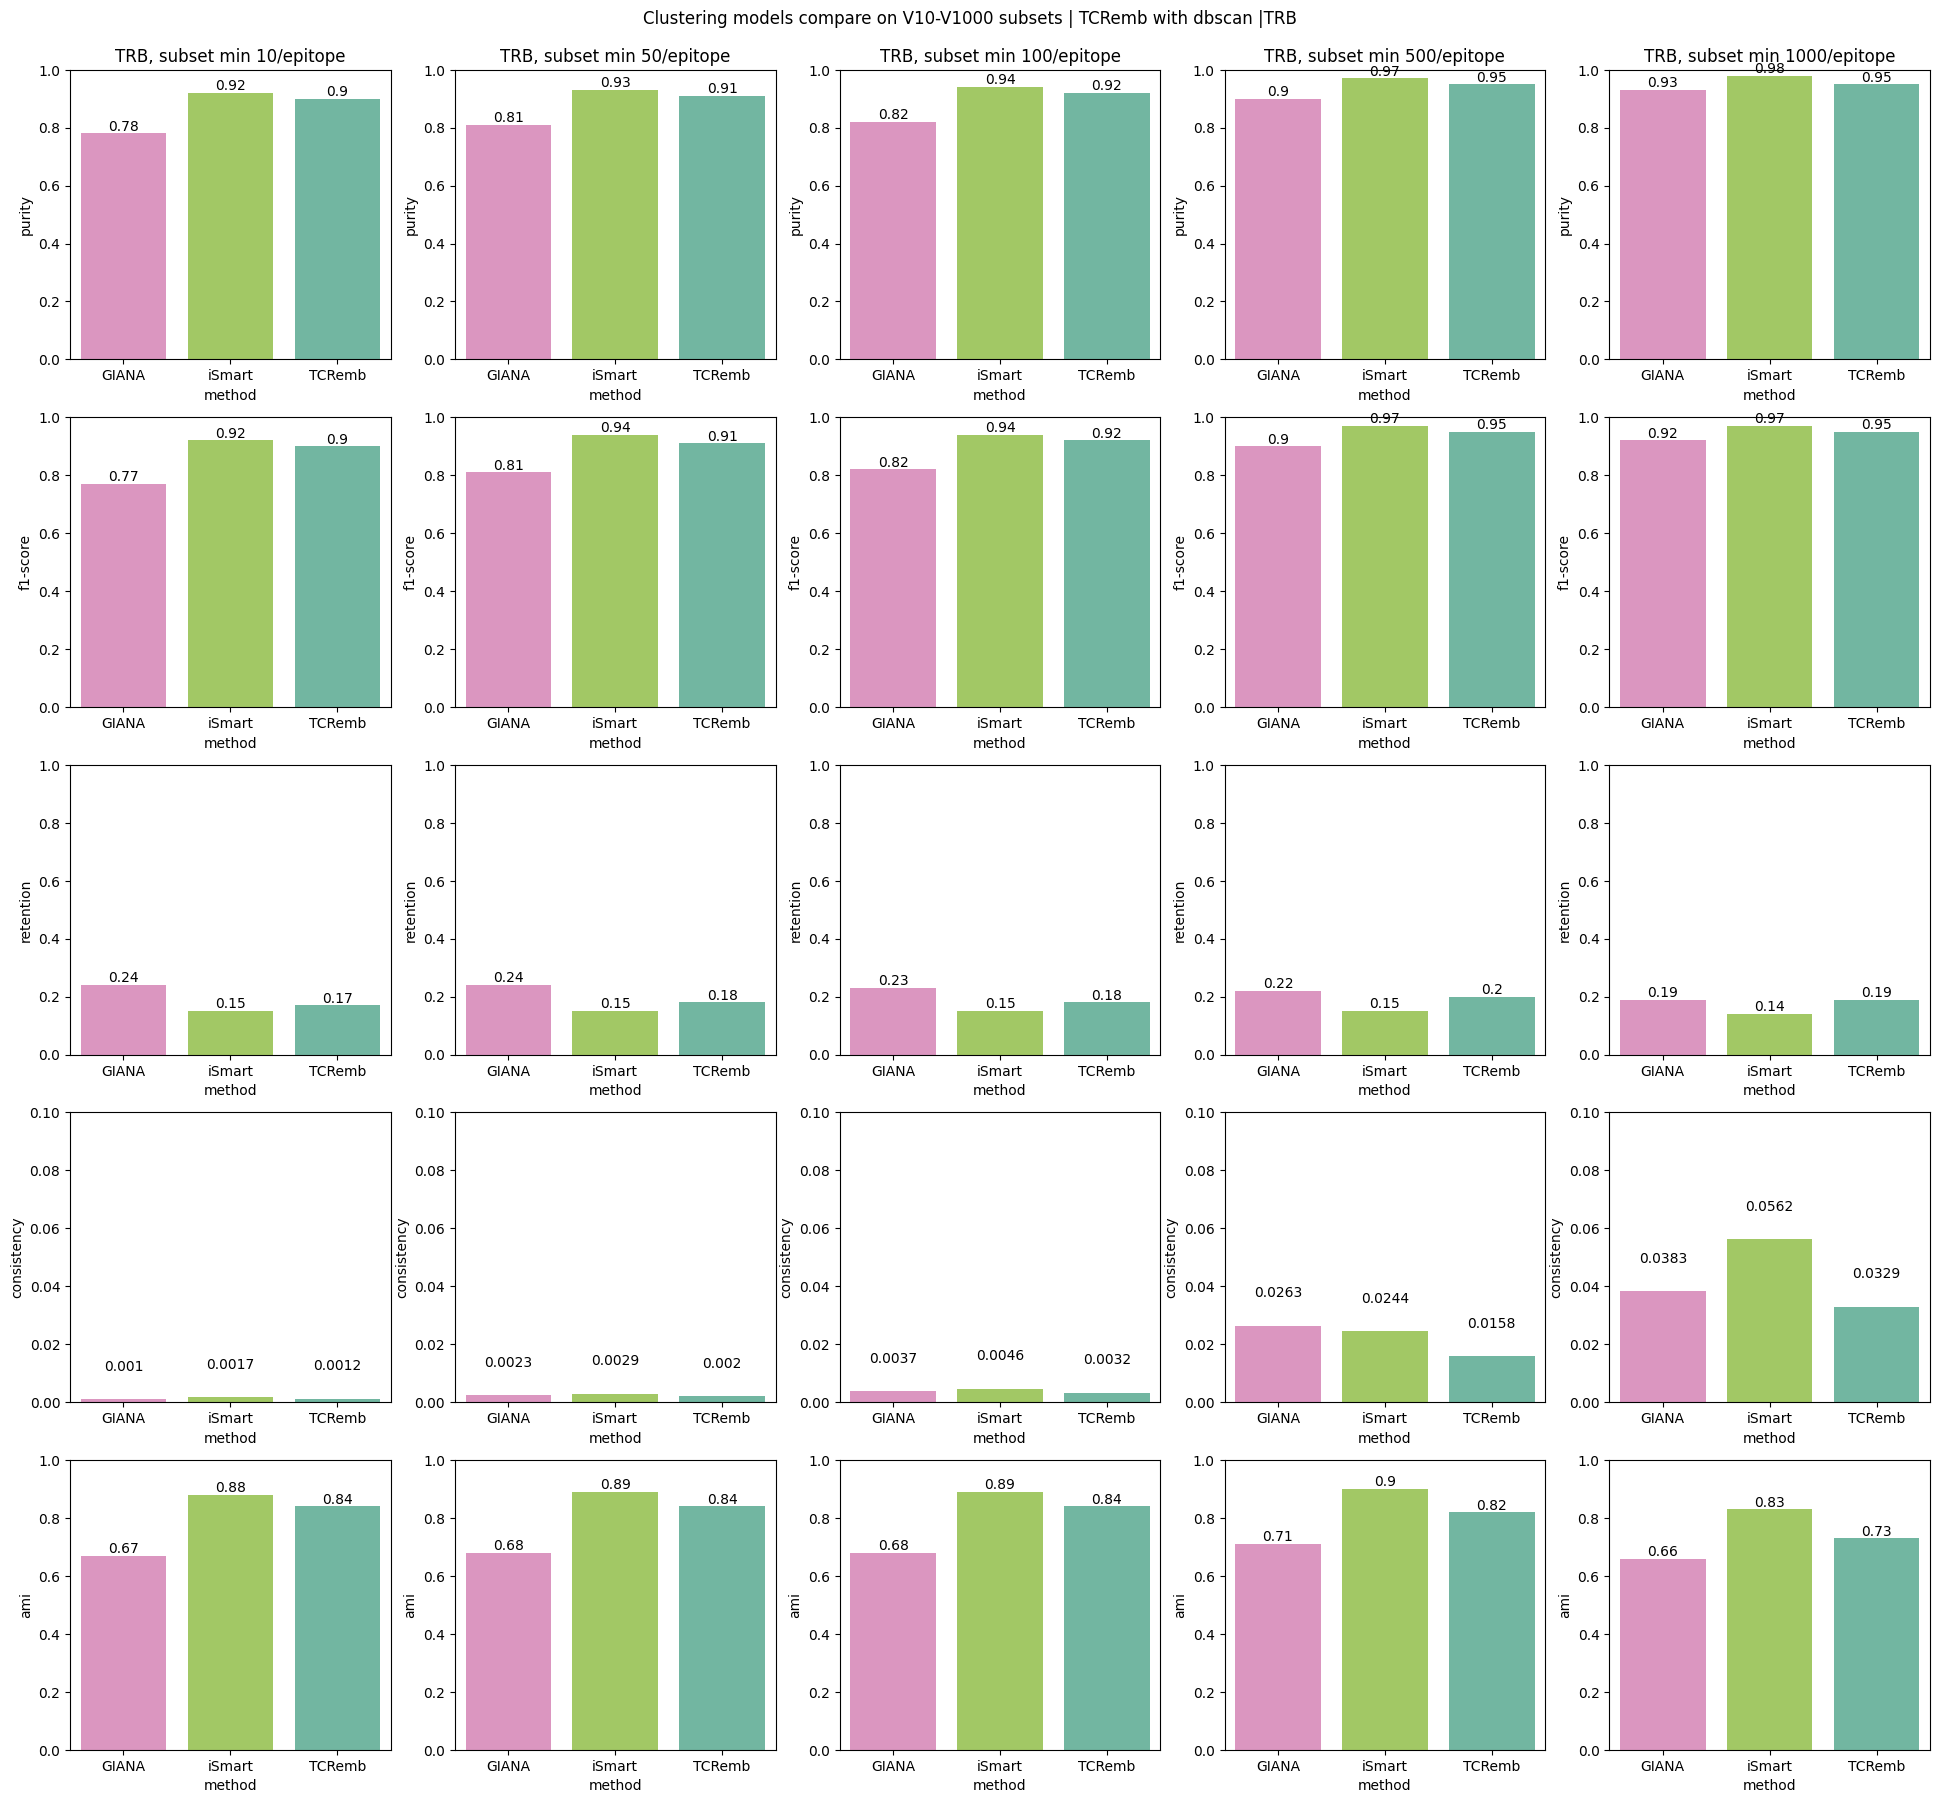

In [24]:
## dbscan

chain = 'TRA'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan | {chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')    
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
plt.savefig(f"results/figures/compare_methods_dbscan_no_dups_{chain}.png")

chain = 'TRB'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan |{chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
plt.savefig(f"results/figures/compare_methods_dbscan_no_dups_{chain}.png")

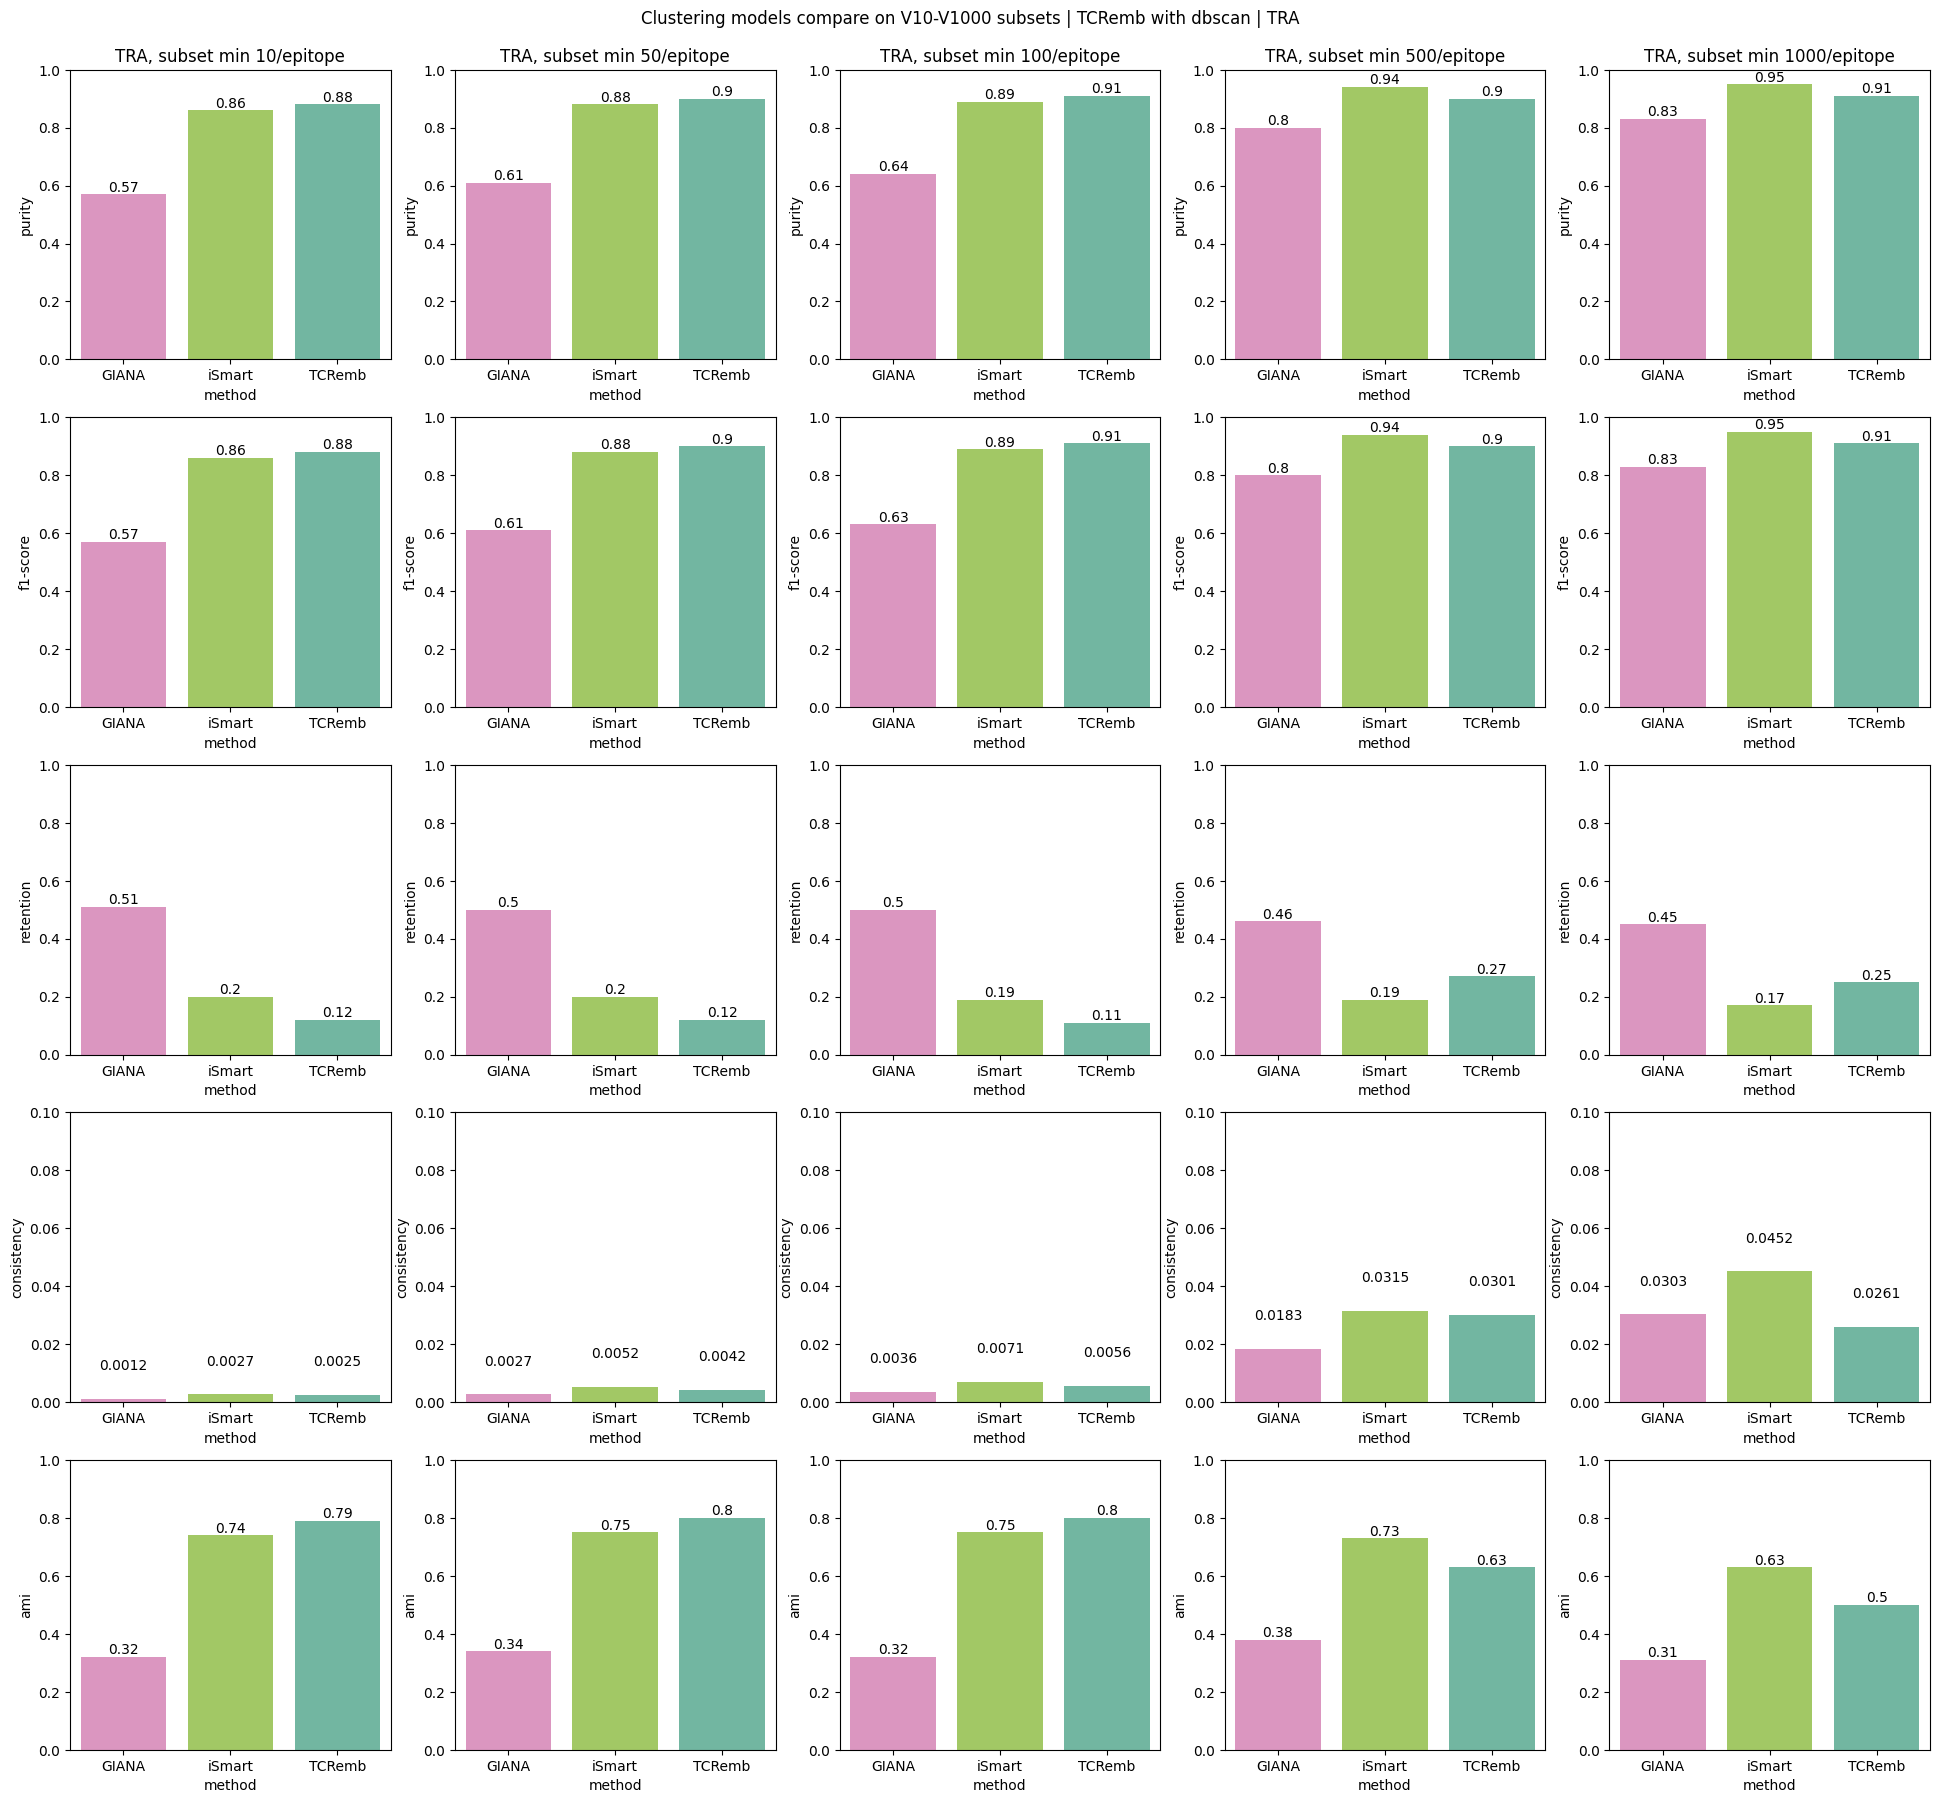

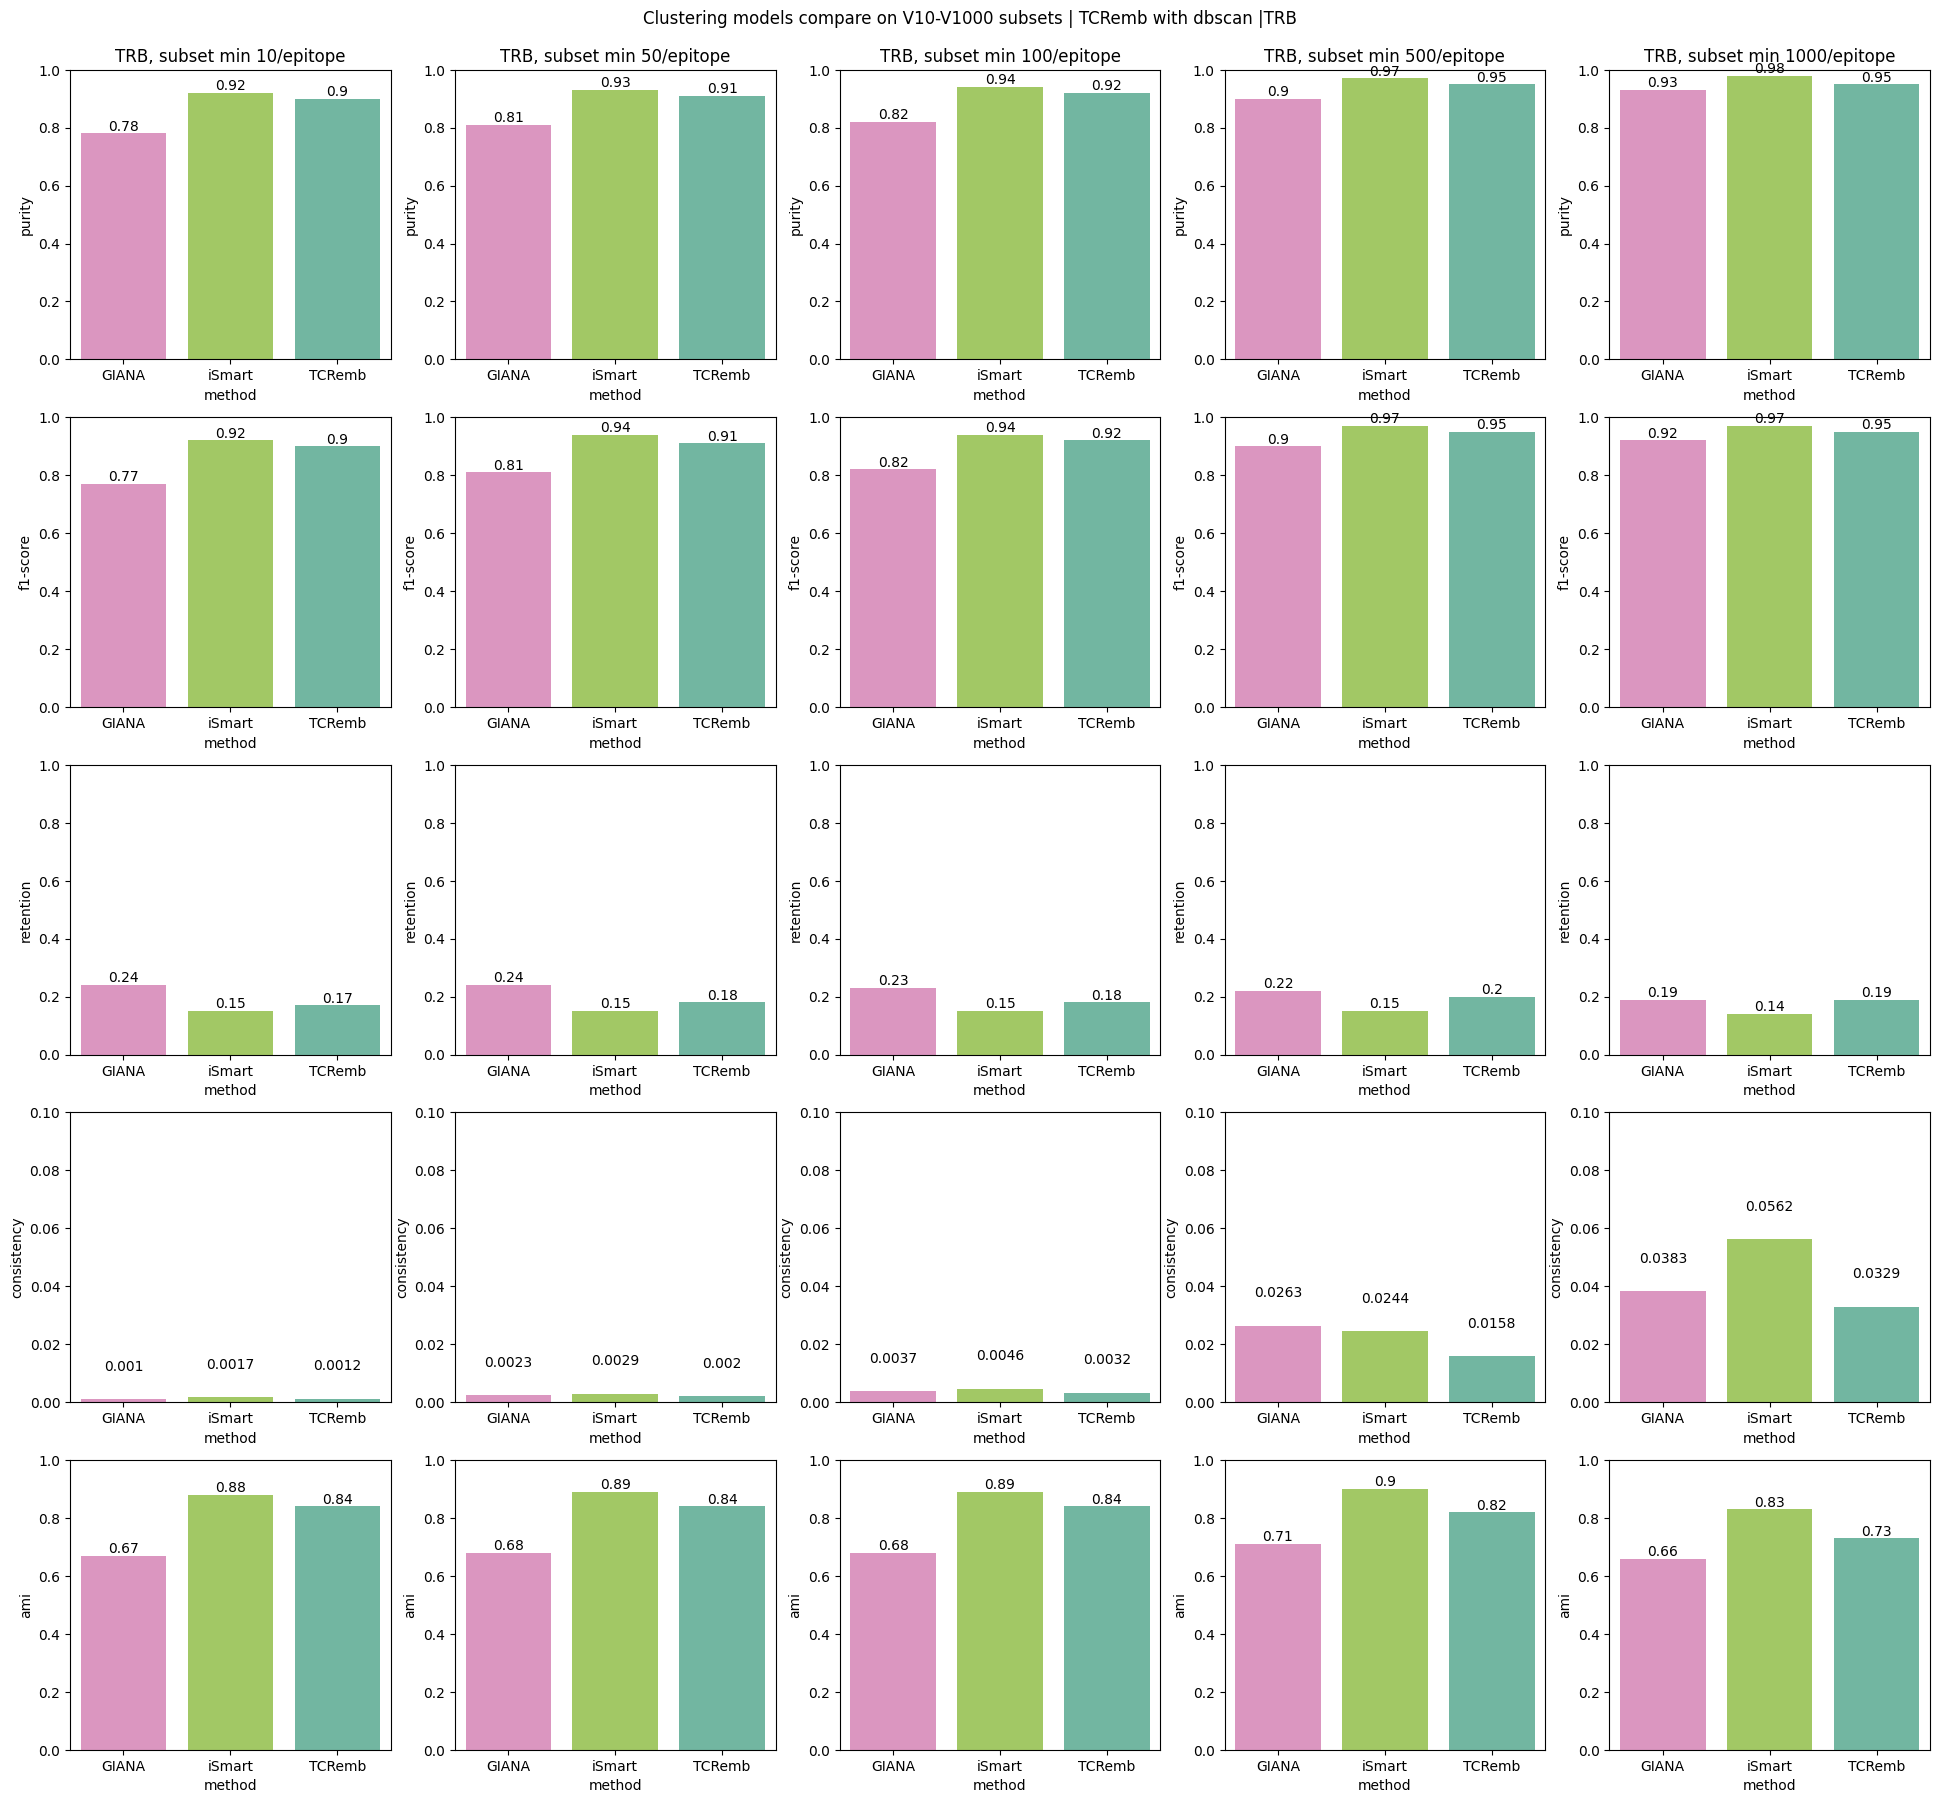

In [41]:
## dbscan

chain = 'TRA'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan | {chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')    
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
#plt.savefig(f"results/figures/compare_methods_dbscan_no_dups_{chain}.png")

chain = 'TRB'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan |{chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
#plt.savefig(f"results/figures/compare_methods_dbscan_no_dups_{chain}.png")

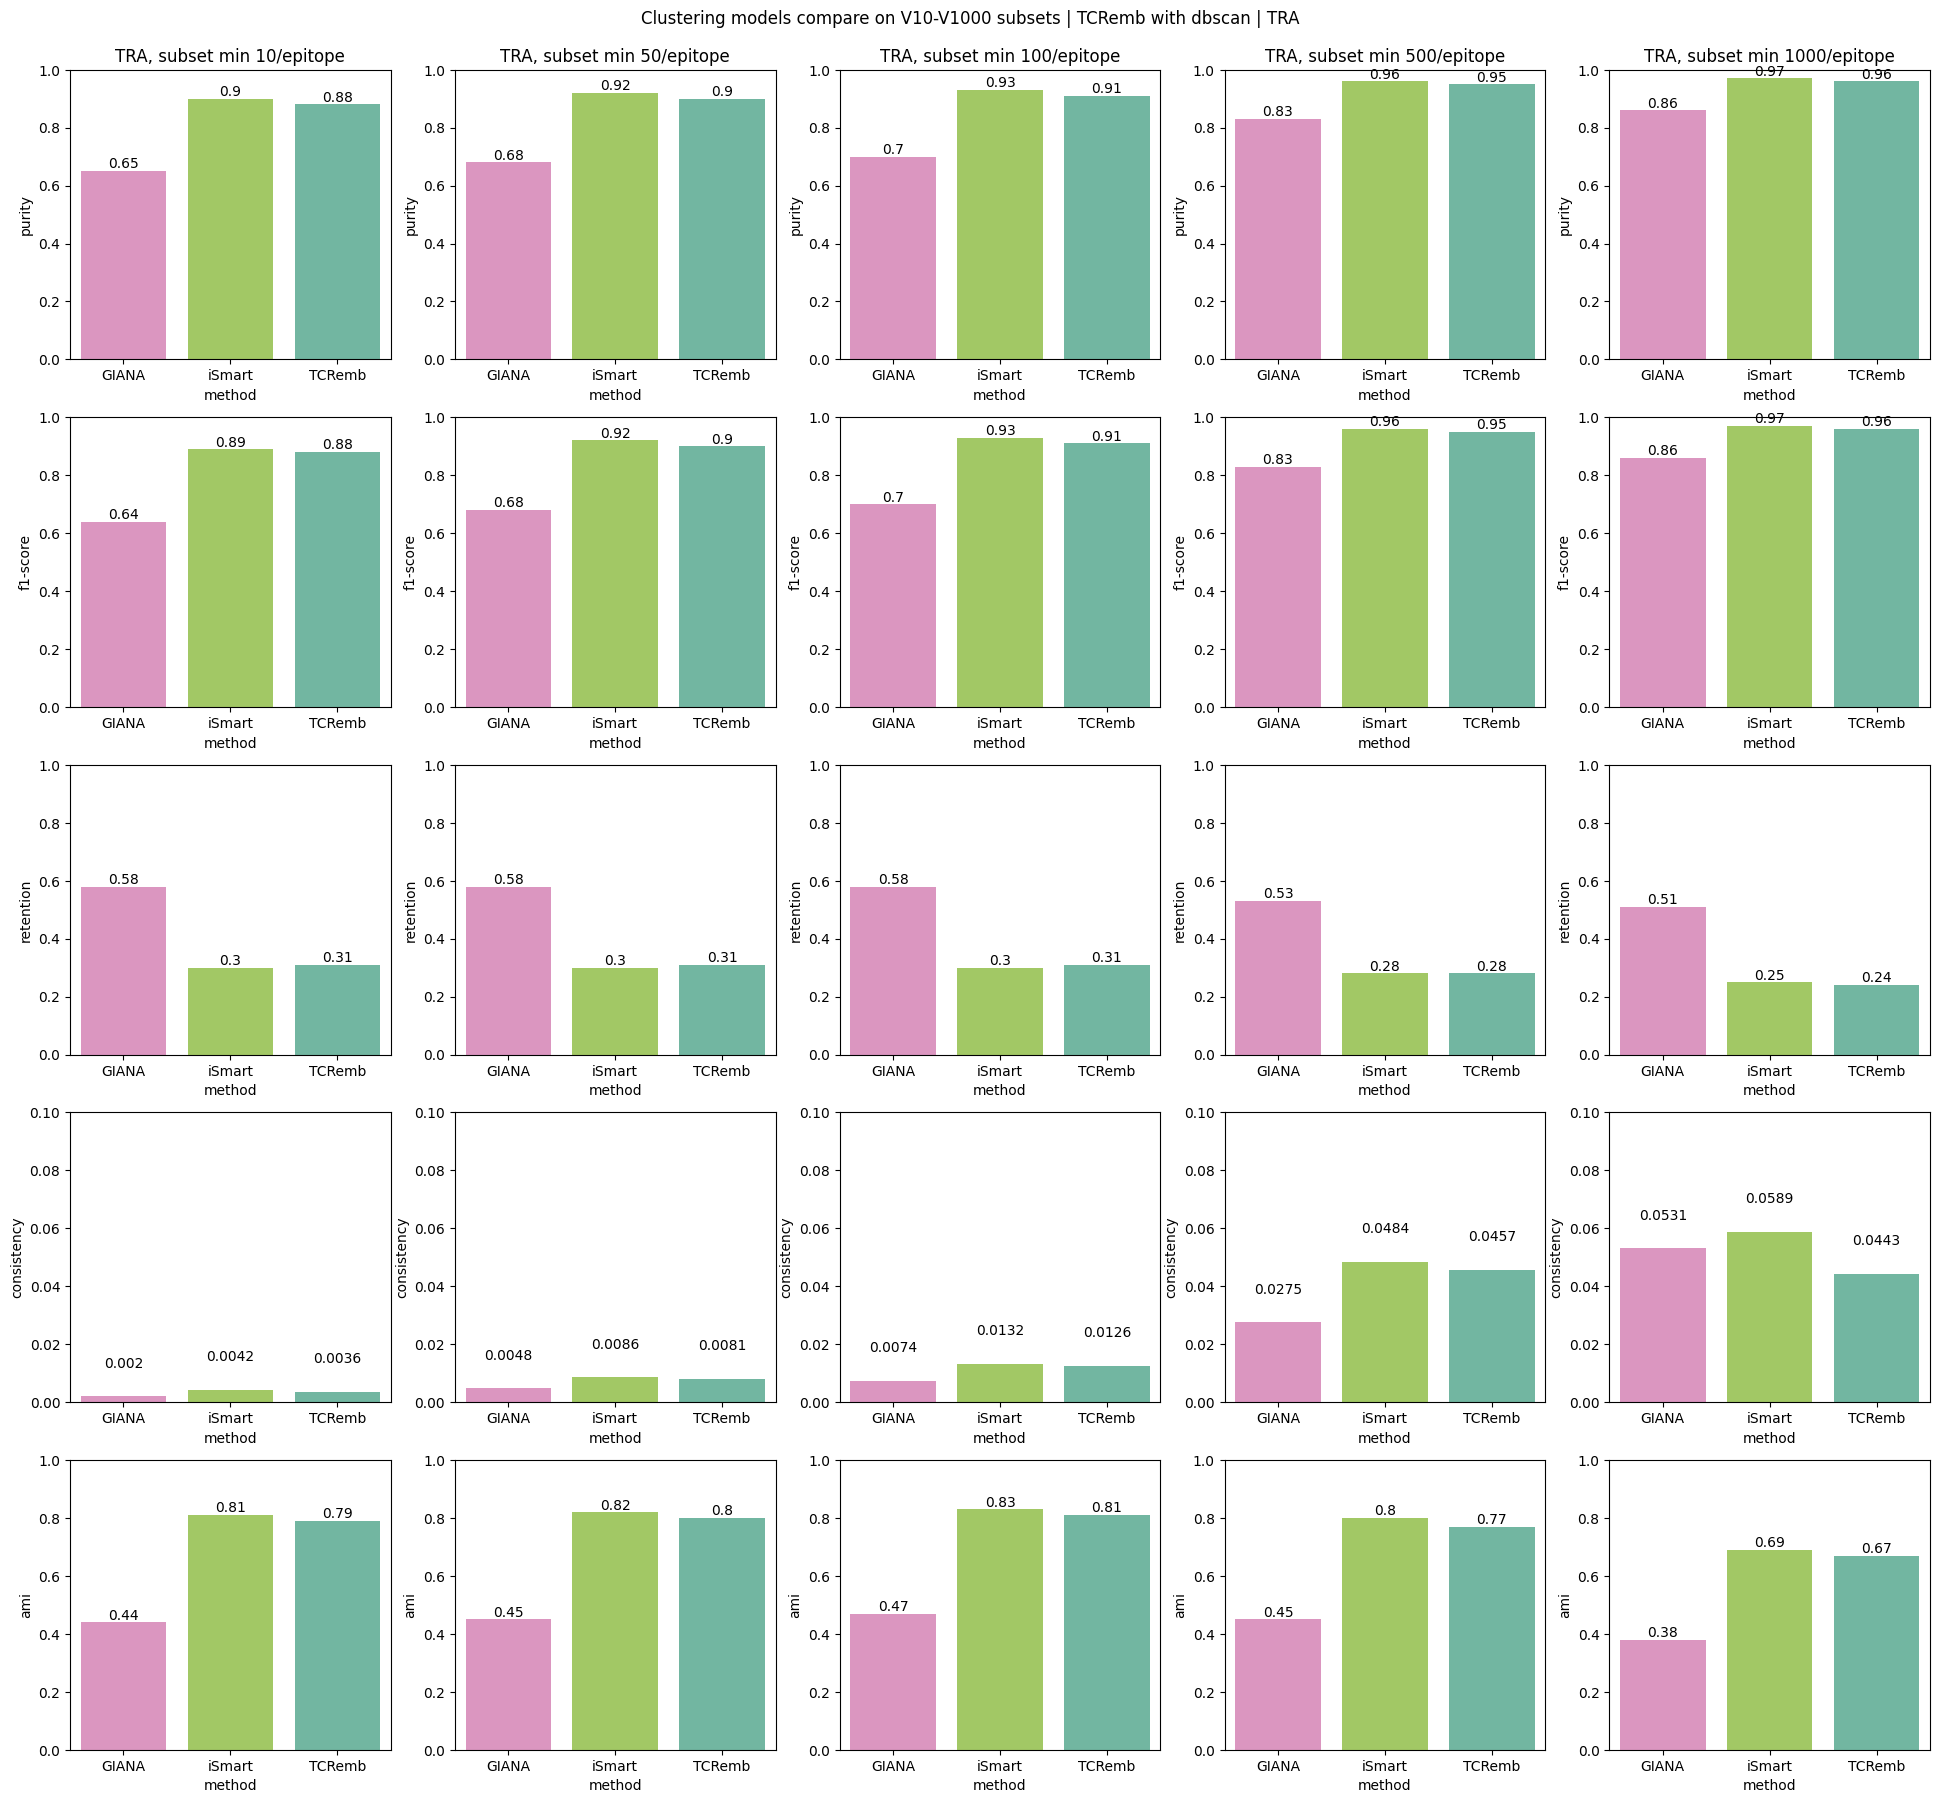

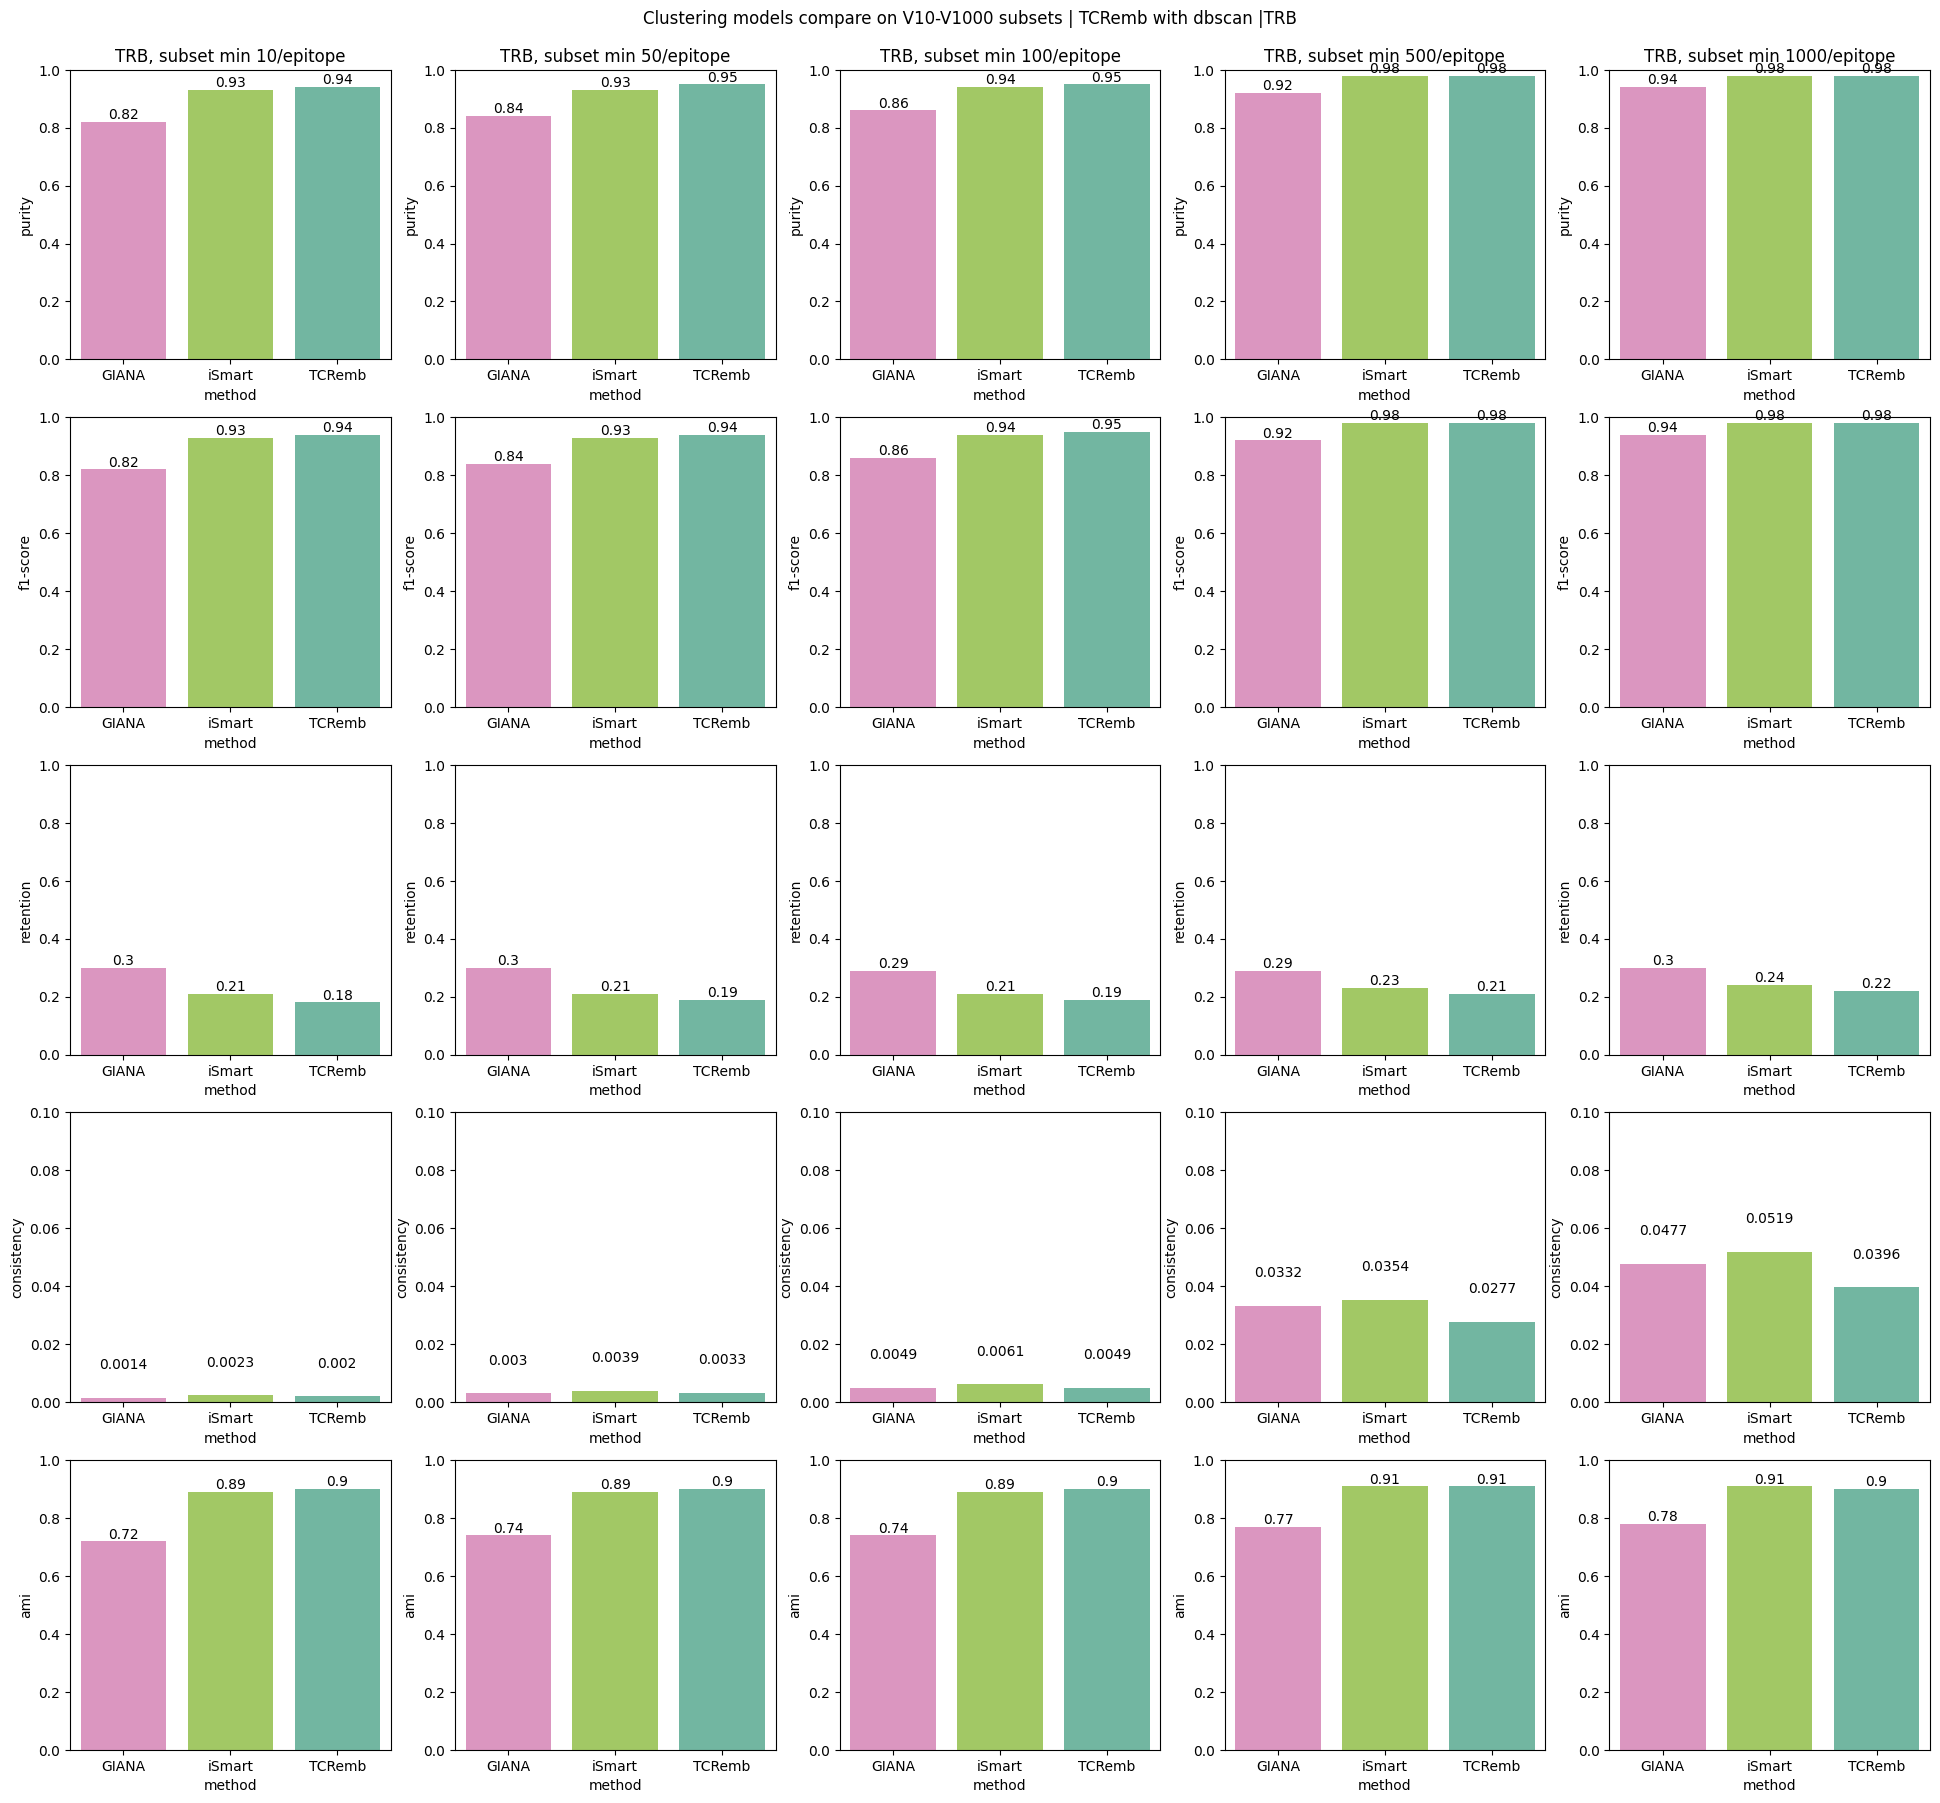

In [17]:
## dbscan

chain = 'TRA'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan | {chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')    
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
plt.savefig(f"results/figures/compare_methods_dbscan_{chain}.png")

chain = 'TRB'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan |{chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
plt.savefig(f"results/figures/compare_methods_dbscan_{chain}.png")

In [25]:
chain='TRA'
metrics_v[chain].to_csv(f"results/tables/compare_methods_dbscan_nodups_{chain}.csv",index=False)
chain='TRB'
metrics_v[chain].to_csv(f"results/tables/compare_methods_dbscan_nodups_{chain}.csv",index=False)

In [42]:
## emp factor 0.75
chain='TRA'
metrics_v[chain]


,v_subset,purity,retention,consistency,ami,precision,recall,f1-score,mean_clustsize,method
0,10,0.57,0.51,0.0012,0.32,0.57,0.57,0.57,5.03,GIANA
1,50,0.61,0.5,0.0027,0.34,0.61,0.61,0.61,4.93,GIANA
2,100,0.64,0.5,0.0036,0.32,0.63,0.64,0.63,4.84,GIANA
3,500,0.8,0.46,0.0183,0.38,0.8,0.8,0.8,4.63,GIANA
4,1000,0.83,0.45,0.0303,0.31,0.83,0.83,0.83,4.64,GIANA
5,10,0.86,0.2,0.0027,0.74,0.86,0.86,0.86,3.37,iSmart
6,50,0.88,0.2,0.0052,0.75,0.88,0.88,0.88,3.45,iSmart
7,100,0.89,0.19,0.0071,0.75,0.89,0.89,0.89,3.45,iSmart
8,500,0.94,0.19,0.0315,0.73,0.94,0.94,0.94,3.87,iSmart
9,1000,0.95,0.17,0.0452,0.63,0.95,0.95,0.95,3.82,iSmart


In [43]:
## emp factor 0.7
chain='TRA'
metrics_v[chain]


,v_subset,purity,retention,consistency,ami,precision,recall,f1-score,mean_clustsize,method
0,10,0.57,0.51,0.0012,0.32,0.57,0.57,0.57,5.03,GIANA
1,50,0.61,0.5,0.0027,0.34,0.61,0.61,0.61,4.93,GIANA
2,100,0.64,0.5,0.0036,0.32,0.63,0.64,0.63,4.84,GIANA
3,500,0.8,0.46,0.0183,0.38,0.8,0.8,0.8,4.63,GIANA
4,1000,0.83,0.45,0.0303,0.31,0.83,0.83,0.83,4.64,GIANA
5,10,0.86,0.2,0.0027,0.74,0.86,0.86,0.86,3.37,iSmart
6,50,0.88,0.2,0.0052,0.75,0.88,0.88,0.88,3.45,iSmart
7,100,0.89,0.19,0.0071,0.75,0.89,0.89,0.89,3.45,iSmart
8,500,0.94,0.19,0.0315,0.73,0.94,0.94,0.94,3.87,iSmart
9,1000,0.95,0.17,0.0452,0.63,0.95,0.95,0.95,3.82,iSmart


In [27]:
## emp factor 0.75
chain='TRB'
metrics_v[chain]


,v_subset,purity,retention,consistency,ami,precision,recall,f1-score,mean_clustsize,method
0,10,0.78,0.24,0.001,0.67,0.77,0.78,0.77,3.64,GIANA
1,50,0.81,0.24,0.0023,0.68,0.81,0.81,0.81,3.64,GIANA
2,100,0.82,0.23,0.0037,0.68,0.82,0.82,0.82,3.75,GIANA
3,500,0.9,0.22,0.0263,0.71,0.9,0.9,0.9,4.32,GIANA
4,1000,0.93,0.19,0.0383,0.66,0.92,0.93,0.92,4.04,GIANA
5,10,0.92,0.15,0.0017,0.88,0.92,0.92,0.92,3.64,iSmart
6,50,0.93,0.15,0.0029,0.89,0.94,0.93,0.94,3.69,iSmart
7,100,0.94,0.15,0.0046,0.89,0.94,0.94,0.94,3.86,iSmart
8,500,0.97,0.15,0.0244,0.9,0.97,0.97,0.97,4.5,iSmart
9,1000,0.98,0.14,0.0562,0.83,0.97,0.98,0.97,4.85,iSmart


In [29]:
## emp factor 0.7
chain='TRB'
metrics_v[chain]


,v_subset,purity,retention,consistency,ami,precision,recall,f1-score,mean_clustsize,method
0,10,0.78,0.24,0.001,0.67,0.77,0.78,0.77,3.64,GIANA
1,50,0.81,0.24,0.0023,0.68,0.81,0.81,0.81,3.64,GIANA
2,100,0.82,0.23,0.0037,0.68,0.82,0.82,0.82,3.75,GIANA
3,500,0.9,0.22,0.0263,0.71,0.9,0.9,0.9,4.32,GIANA
4,1000,0.93,0.19,0.0383,0.66,0.92,0.93,0.92,4.04,GIANA
5,10,0.92,0.15,0.0017,0.88,0.92,0.92,0.92,3.64,iSmart
6,50,0.93,0.15,0.0029,0.89,0.94,0.93,0.94,3.69,iSmart
7,100,0.94,0.15,0.0046,0.89,0.94,0.94,0.94,3.86,iSmart
8,500,0.97,0.15,0.0244,0.9,0.97,0.97,0.97,4.5,iSmart
9,1000,0.98,0.14,0.0562,0.83,0.97,0.98,0.97,4.85,iSmart


In [23]:
chain='TRA'
metrics_v[chain].to_csv(f"results/tables/compare_methods_dbscan_{chain}.csv",index=False)
chain='TRB'
metrics_v[chain].to_csv(f"results/tables/compare_methods_dbscan_{chain}.csv",index=False)

In [25]:
metrics_v['TRB']

,v_subset,purity,retention,consistency,ami,precision,recall,f1-score,mean_clustsize,method
0,10,0.82,0.3,0.0014,0.72,0.81,0.82,0.82,5.48,GIANA
1,50,0.84,0.3,0.003,0.74,0.84,0.84,0.84,5.64,GIANA
2,100,0.86,0.29,0.0049,0.74,0.86,0.86,0.86,5.73,GIANA
3,500,0.92,0.29,0.0332,0.77,0.92,0.92,0.92,6.77,GIANA
4,1000,0.94,0.3,0.0477,0.78,0.94,0.94,0.94,7.12,GIANA
5,10,0.93,0.21,0.0023,0.89,0.93,0.93,0.93,6.13,iSmart
6,50,0.93,0.21,0.0039,0.89,0.93,0.93,0.93,6.37,iSmart
7,100,0.94,0.21,0.0061,0.89,0.94,0.94,0.94,6.64,iSmart
8,500,0.98,0.23,0.0354,0.91,0.98,0.98,0.98,7.86,iSmart
9,1000,0.98,0.24,0.0519,0.91,0.98,0.98,0.98,8.54,iSmart


In [ ]:
chain = 'TRA'
fig, axes = plt.subplots(5,5, figsize = (20,18))
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    ax_n+=1

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

In [ ]:
chain = 'TRA'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_enriched[chain]).T])
#metrics_v[chain]['method'] = metrics_v[chain].index

chain = 'TRB'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_enriched[chain]).T])

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

plt.savefig(f"results/figures/compare_methods_3.png")

# Classification

## ATM_TCR

2650 11772 505 6706
accuracy   0.4325
auc        0.6519
f1macro    0.4118
f1micro    0.4325
loss       442818.7955
precision0 0.8399
precision1 0.3629
recall0    0.1837
recall1    0.9300

In [ ]:
atm_results_path = '/home/ykremlyakova/apps/ATM-TCR/result/pred_my_model_vdjdb_trb_atmtcr_test.csv'
real_test_path = '/home/ykremlyakova/projects/tcr_emb/data/data_preped/vdjdb_trb_atmtcr_test.csv'

In [ ]:
!pwd

In [ ]:
real_test = pd.read_csv(real_test_path,header=None)
real_test

In [ ]:
atm = pd.read_csv(atm_results_path, sep='\t',header=None)
atm = atm.rename({0:'antigen.epitope',1:'cdr3aa',2:'bind',3:'pred'},axis=1)

In [ ]:
epitopes_list = ['CINGVCWTV',
 'ELAGIGILTV',
 'FRDYVDRFYKTLRAEQASQE',
 'GILGFVFTL',
 'GLCTLVAML',
 'KRWIILGLNK',
 'LLLGIGILV',
 'LLWNGPMAV',
 'NLVPMVATV',
 'PKYVKQNTLKLAT',
 'SPRWYFYYL',
 'TFEYVSQPFLMDLE',
 'TPRVTGGGAM',
 'TTDPSFLGRY',
 'YLQPRTFLL']

In [ ]:
atm_e = atm[atm['antigen.epitope'].isin(epitopes_list)]

In [ ]:
#atm_e = atm_e[atm_e['bind']==1]

In [ ]:
roc_res = []
for e in epitopes_list:
    r={}
    r['class']= e
    r['roc_auc'] = ml_utils.roc_auc_count_binary(atm_e[atm_e['antigen.epitope']==e]['bind'], atm_e[atm_e['antigen.epitope']==e]['pred'])
    roc_res.append(r)

In [ ]:
roc_res


In [ ]:
atm_e[atm_e['pred'].isna()]